In [ ]:
pip install s3fs

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import s3fs
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Reshape, Input, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
df = pd.read_csv('s3://skysquad/DATASET/zurich_dataset.csv')
df_1= df.copy()

def calculate_index(group):
    """Calculates the index based on 'flight_id', 'lastseen', and 'timedelta'"""
    group = group.sort_values('timedelta')  # Sort within groups by timedelta
    group['index'] = range(1, len(group) + 1)  # Assign the index
    return group

# Apply the calculation to groups based on 'flight_id' and 'lastseen'
df = df.groupby(['flight_id']).apply(calculate_index)



df.describe()

,altitude,geoaltitude,groundspeed,latitude,longitude,distance,runway,initial_bearing,track_unwrapped,x,y,timedelta,index
count,71400.000000,70000.000000,71400.000000,71400.000000,71400.000000,71400.000000,71400.0,71400.000000,71400.000000,71400.00000,7.140000e+04,71400.000000,71400.00000
mean,9396.761917,9519.755357,245.503466,47.448484,8.618264,15.820186,34.0,181.316006,198.675713,471211.82180,5.255228e+06,538.760504,100.50000
std,4772.387226,4815.428025,64.907899,0.208800,0.323547,9.432438,0.0,78.019344,148.503632,24368.53320,2.321372e+04,343.748079,57.73471
min,1250.000000,1475.000000,109.590051,46.806290,7.577397,0.426749,34.0,34.533984,-386.399934,392973.17200,5.183786e+06,0.000000,1.00000
25%,5525.000000,5600.000000,194.239375,47.300491,8.557082,8.947006,34.0,102.428740,120.454797,466616.46950,5.238724e+06,256.000000,50.75000
50%,9250.000000,9350.000000,245.617377,47.404861,8.640254,13.927784,34.0,189.256912,181.005086,472871.43745,5.250370e+06,515.000000,100.50000
75%,13000.000000,13200.000000,289.347292,47.568192,8.773780,20.696456,34.0,247.515753,290.588616,482930.17970,5.268758e+06,777.000000,150.25000
max,30800.000000,30025.000000,481.614575,48.129474,9.524803,39.955694,34.0,352.139815,1057.306205,539504.65950,5.330907e+06,2248.000000,200.00000


In [ ]:
column_names = ['index', 'min_longitude', 'max_longitude', 'mean_longitude',
                'min_latitude', 'max_latitude', 'mean_latitude',
                'min_a  ltitude', 'max_altitude', 'mean_altitude',
                'min_ground_speed', 'max_ground_speed', 'mean_ground_speed']

# Create an empty DataFrame
range_df = pd.DataFrame(columns=column_names)

# Define the statistics you want to calculate
statistics = ['min', 'max', 'mean']

# Columns to calculate statistics on
data_columns = ['longitude', 'latitude', 'altitude', 'groundspeed']

# Create an empty DataFrame to store the results
result_df = pd.DataFrame()

# Loop through indices from 1 to 200
for index in range(1, 201):
    # Filter data for the current index
    filtered_df = df[df['index'] == index]

    # Skip if there's no data for this index
    if filtered_df.empty:
        continue

    # Calculate statistics
    for col in data_columns:
        for stat in statistics:
            result_df.loc[index, f'{col}_{stat}'] = getattr(filtered_df[col], stat)()

result_df

,longitude_min,longitude_max,longitude_mean,latitude_min,latitude_max,latitude_mean,altitude_min,altitude_max,altitude_mean,groundspeed_min,groundspeed_max,groundspeed_mean
1,7.577397,9.524803,8.566108,46.806290,48.129474,47.695498,12975.0,30800.0,17629.411765,228.034888,481.614575,340.581897
2,7.587227,9.516273,8.565579,46.811115,48.123516,47.692794,12975.0,30700.0,17525.023343,228.054621,480.350498,339.394675
3,7.596771,9.509583,8.565117,46.815720,48.116533,47.690116,12975.0,30600.0,17421.352708,228.054621,478.137642,338.201402
4,7.606384,9.501413,8.564709,46.819656,48.111505,47.687237,12975.0,30500.0,17317.857143,228.078737,476.563330,337.090580
5,7.614863,9.493244,8.564263,46.824336,48.106570,47.684358,12975.0,30350.0,17215.721289,228.078737,475.302651,335.902087
...,...,...,...,...,...,...,...,...,...,...,...,...
196,8.562293,8.575252,8.566134,47.418575,47.437382,47.431839,1475.0,2550.0,1876.995798,115.870517,163.719131,142.596093
197,8.561096,8.570778,8.563914,47.425186,47.439198,47.435074,1425.0,2450.0,1798.494398,114.965113,164.200954,142.392434
198,8.559899,8.566660,8.561689,47.431051,47.440920,47.438302,1375.0,2350.0,1718.592437,114.127024,164.200954,142.266406
199,8.558350,8.561730,8.559472,47.438267,47.443039,47.441525,1312.5,2250.0,1640.091036,114.542469,164.623671,142.238134


In [ ]:
pip install tensorflow-addons


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras import backend as K

def preprocess_flight_data(df):
    df['lastseen'] = pd.to_datetime(df['lastseen'])
    routes = []

    for flight_id, group in df.groupby('flight_id'):
        for i in range(0, len(group), 200):
            route = group.iloc[i:i+200][['latitude', 'longitude', 'altitude']]
            if len(route) == 200:
                route = route.values
                routes.append(route)
    return np.array(routes)

# Reset the index of the DataFrame before preprocessing
df.reset_index(drop=True, inplace=True)  # Reset index without adding it as a column

# Preprocess the data
from sklearn.preprocessing import StandardScaler
# Preprocess flight data to get routes_data
routes_data = preprocess_flight_data(df)


# Assuming you have loaded and preprocessed your flight track data as 'routes_data_scaled' using MinMaxScaler
scaler = MinMaxScaler()
routes_data_scaled = scaler.fit_transform(routes_data.reshape(-1, routes_data.shape[-1])).reshape(routes_data.shape)
# Define latent dimension
latent_dim = 100

# Wasserstein loss function
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

# Generator model with modified output layer to generate values within specific ranges
def build_generator(latent_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_dim=latent_dim),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(600)  # No activation function here
    ])
    return model

# Discriminator model
def build_discriminator(data_shape):
    model = models.Sequential([
        layers.Flatten(input_shape=(data_shape,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)  # No activation function for Wasserstein GAN
    ])
    return model

# GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential([generator, discriminator])
    return model

# Compiling the models with Wasserstein loss and Wasserstein optimizer
generator = build_generator(latent_dim)
discriminator = build_discriminator(routes_data_scaled.shape[1] * routes_data_scaled.shape[2])
optimizer = AdamW(learning_rate=0.0002, beta_1=0.5, beta_2=0.9, weight_decay=0.01)  # Adjust weight_decay as needed
discriminator.compile(optimizer=optimizer, loss=wasserstein_loss)
gan = build_gan(generator, discriminator)
gan.compile(optimizer=optimizer, loss=wasserstein_loss)

# Training function
def train(gan, generator, discriminator, routes_data, epochs, batch_size):
    flat_dim = routes_data.shape[1] * routes_data.shape[2]  # This should be 200*3=600
    for epoch in range(epochs):
        # Real routes
        idx = np.random.randint(0, routes_data.shape[0], batch_size)
        real_routes = routes_data[idx].reshape(batch_size, flat_dim)

        # Synthetic routes
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_routes = generator.predict(noise).reshape(batch_size, flat_dim)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_routes, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_routes, -np.ones((batch_size, 1)))  # Note the negative label for fake routes
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Generator training
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Progress logging
        print(f"Epoch: {epoch+1}/{epochs}, D Loss: {d_loss}, G Loss: {g_loss}")

# Parameters
epochs = 10000
batch_size = 128

# Start training
train(gan, generator, discriminator, routes_data_scaled, epochs, batch_size)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 5ms/step
Epoch: 7501/10000, D Loss: -0.19068436324596405, G Loss: -0.3062654733657837
4/4 [==============================] - 0s 6ms/step
Epoch: 7502/10000, D Loss: -0.18079081177711487, G Loss: -0.31449976563453674
4/4 [==============================] - 0s 6ms/step
Epoch: 7503/10000, D Loss: -0.1743147075176239, G Loss: -0.3082079589366913
4/4 [==============================] - 0s 6ms/step
Epoch: 7504/10000, D Loss: -0.1827324628829956, G Loss: -0.31225770711898804
4/4 [==============================] - 0s 5ms/step
Epoch: 7505/10000, D Loss: -0.1786334216594696, G Loss: -0.3100445866584778
4/4 [==============================] - 0s 6ms/step
Epoch: 7506/10000, D Loss: -0.18415704369544983, G Loss: -0.31106656789779663
4/4 [==============================] - 0s 6ms/step
Epoch: 7507/10000, D Loss: -0.18494391441345215, G Loss: -0.3107892870903015
4/4 [==============================] - 0s 8ms/step
Ep

Streaming output truncated to the last 5000 lines.
 [-2.92249222e+01  2.03156433e+01  4.56706196e-01]
 [-2.92203827e+01  2.03163261e+01  4.53503489e-01]
 [-2.92171535e+01  2.03171062e+01  4.49555069e-01]
 [-2.92127781e+01  2.03177433e+01  4.46081311e-01]
 [-2.92092400e+01  2.03186512e+01  4.42608356e-01]
 [-2.92047405e+01  2.03193207e+01  4.38288391e-01]
 [-2.92015285e+01  2.03201008e+01  4.31328654e-01]
 [-2.91970615e+01  2.03209038e+01  4.23895240e-01]
 [-2.91935940e+01  2.03215313e+01  4.16647404e-01]
 [-2.91890526e+01  2.03221531e+01  4.11191851e-01]
 [-2.91857243e+01  2.03228760e+01  4.06869501e-01]
 [-2.91812134e+01  2.03235168e+01  4.04238611e-01]
 [-2.91779861e+01  2.03241253e+01  4.00288016e-01]
 [-2.91742134e+01  2.03249245e+01  3.95862848e-01]
 [-2.91694107e+01  2.03257923e+01  3.94262046e-01]
 [-2.91661644e+01  2.03263874e+01  3.92847568e-01]
 [-2.91614971e+01  2.03272800e+01  3.91246021e-01]
 [-2.91578770e+01  2.03280659e+01  3.87580216e-01]
 [-2.91633625e+01  2.03290024e+

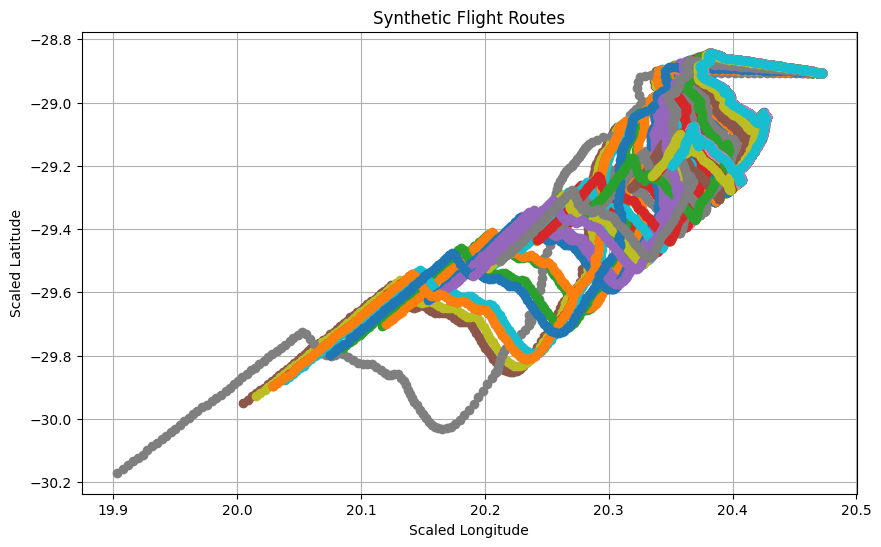

In [ ]:
# Generating synthetic routes based on specific ranges at each data point
def generate_synthetic_routes(generator, num_routes, result_df, latent_dim, scaler):
    noise = np.random.normal(0, 1, (num_routes, latent_dim))
    synthetic_routes = generator.predict(noise)
    synthetic_routes = synthetic_routes.reshape(num_routes, 200, 3)

    # Modify synthetic routes based on min and max from result_df using MinMaxScaler
    for i in range(num_routes):
        for j in range(200):  # Assuming 200 points in a route
            min_longitude = result_df.loc[j+1, 'longitude_min']
            max_longitude = result_df.loc[j+1, 'longitude_max']
            min_latitude = result_df.loc[j+1, 'latitude_min']
            max_latitude = result_df.loc[j+1, 'latitude_max']
            min_altitude = result_df.loc[j+1, 'altitude_min']
            max_altitude = result_df.loc[j+1, 'altitude_max']

            # Inverse transform using MinMaxScaler to get original scale
            synthetic_routes[i, j, 0] = (synthetic_routes[i, j, 0] * (max_longitude - min_longitude)) + min_longitude
            synthetic_routes[i, j, 1] = (synthetic_routes[i, j, 1] * (max_latitude - min_latitude)) + min_latitude
            synthetic_routes[i, j, 2] = (synthetic_routes[i, j, 2] * (max_altitude - min_altitude)) + min_altitude

    return synthetic_routes

# Assuming synthetic_routes is defined here or generated before plotting
synthetic_routes = generate_synthetic_routes(generator, 100, result_df, latent_dim, scaler)

def plot_synthetic_routes(synthetic_routes, scaler):
    plt.figure(figsize=(10, 6))
    for route in synthetic_routes:
        # Scale all three features (longitude, latitude, altitude) back to original scale
        scaled_route = scaler.transform(route)

        # Print original and scaled values for verification
        print("Original Route:")
        print(route)
        print("Scaled Route:")
        print(scaled_route)

        plt.plot(scaled_route[:, 1], scaled_route[:, 0], marker='o')  # Plot longitude vs latitude
    plt.title('Synthetic Flight Routes')
    plt.xlabel('Scaled Longitude')
    plt.ylabel('Scaled Latitude')
    plt.grid(True)
    plt.show()

plot_synthetic_routes(synthetic_routes, scaler)


       Longitude   Latitude  Altitude
0     -29.198561  20.351252  0.580553
1     -29.195364  20.352039  0.579520
2     -29.191891  20.352587  0.578485
3     -29.188725  20.353205  0.577451
4     -29.186153  20.354099  0.575902
...          ...        ...       ...
19995 -28.900021  20.461523  0.007985
19996 -28.901678  20.464170  0.005761
19997 -28.903252  20.466536  0.005346
19998 -28.905199  20.469444  0.003262
19999 -28.906858  20.471838 -0.000189

[20000 rows x 3 columns]


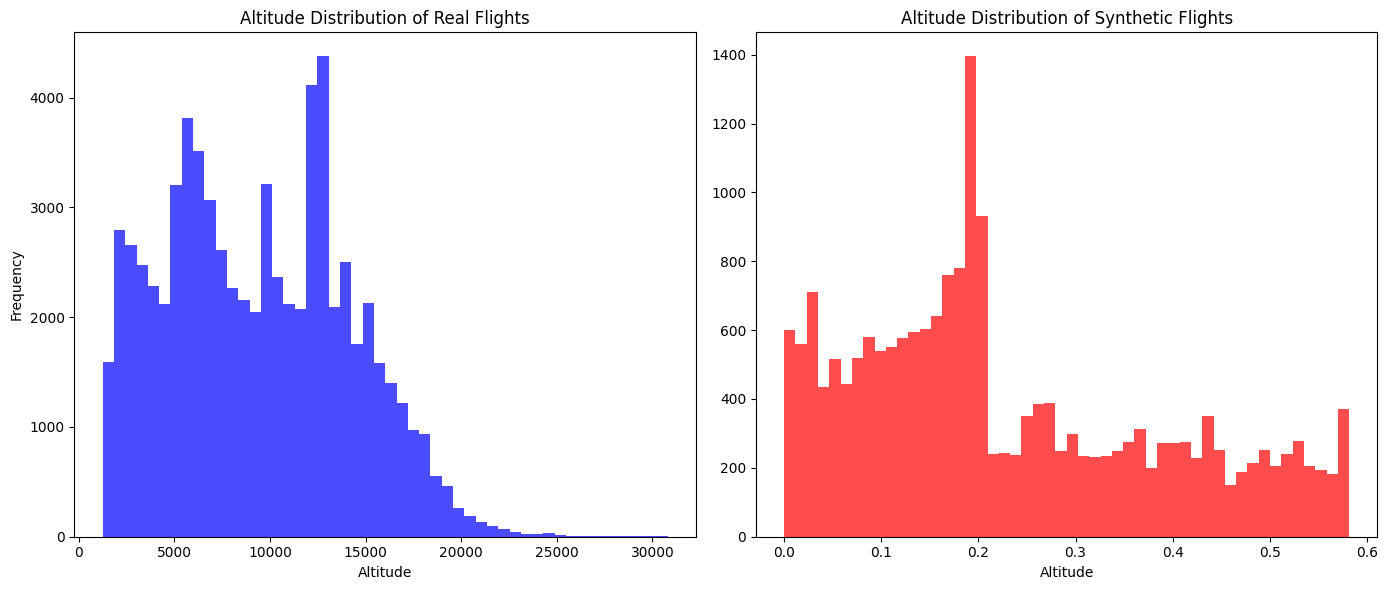

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create an empty DataFrame to store the scaled synthetic tracks
df_columns = ['Longitude', 'Latitude', 'Altitude']
synthetic_flights_df = pd.DataFrame(columns=df_columns)

# Iterate through each synthetic route, scale the values, and add them to the DataFrame
for route in synthetic_routes:
    scaled_route = scaler.transform(route)  # Scale all three features (longitude, latitude, altitude)
    df_temp = pd.DataFrame(scaled_route, columns=df_columns)
    synthetic_flights_df = pd.concat([synthetic_flights_df, df_temp], ignore_index=True)

# Print the DataFrame containing scaled synthetic tracks
print(synthetic_flights_df)

# Loading the datasets (assuming real_flights_df is already defined in your code)
real_flights_df = df_1.copy()

# Remove NaN values from synthetic_altitudes
synthetic_altitudes = synthetic_flights_df['Altitude'].dropna()

# Altitude Distribution for Real vs. Synthetic Flights
plt.figure(figsize=(14, 6))
real_altitudes = real_flights_df['altitude'].dropna()

plt.subplot(1, 2, 1)
plt.hist(real_altitudes, bins=50, color='blue', alpha=0.7, label='Real Flights')
plt.title('Altitude Distribution of Real Flights')
plt.xlabel('Altitude')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(synthetic_altitudes, bins=50, color='red', alpha=0.7, label='Synthetic Flights')
plt.title('Altitude Distribution of Synthetic Flights')
plt.xlabel('Altitude')

plt.tight_layout()
plt.show()


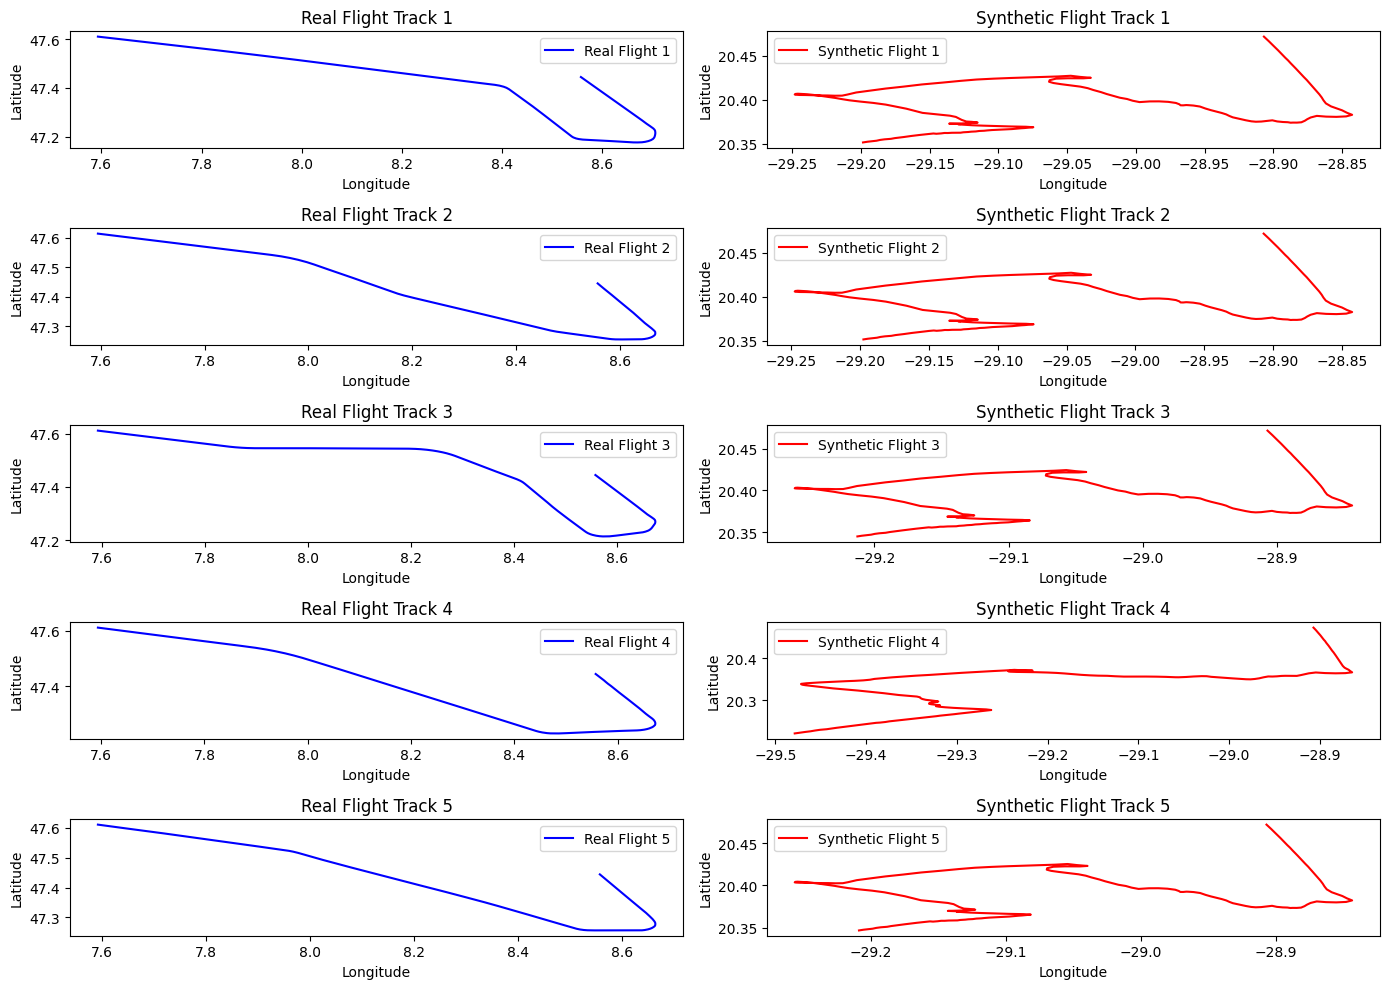

In [ ]:
import matplotlib.pyplot as plt

# Assuming synthetic_flights_df is defined and contains the synthetic flight tracks data

plt.figure(figsize=(14, 10))

for i in range(5):
    # Plot real flights
    real_latitudes = real_flights_df[real_flights_df['flight_id'] == real_flights_df['flight_id'].unique()[i]]['latitude']
    real_longitudes = real_flights_df[real_flights_df['flight_id'] == real_flights_df['flight_id'].unique()[i]]['longitude']
    plt.subplot(5, 2, 2*i+1)
    plt.plot(real_longitudes, real_latitudes, 'b-', label=f'Real Flight {i+1}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Real Flight Track {i+1}')
    plt.legend()

    # Plot synthetic flights
    synthetic_flight = synthetic_flights_df.iloc[i*200:i*200+200]  # Assuming each track has 200 points
    synthetic_latitudes = synthetic_flight['Latitude']
    synthetic_longitudes = synthetic_flight['Longitude']
    plt.subplot(5, 2, 2*(i+1))
    plt.plot(synthetic_longitudes, synthetic_latitudes, 'r-', label=f'Synthetic Flight {i+1}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Synthetic Flight Track {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()
